In [62]:
import numpy as np
import scipy.stats
import dalmatian
import pandas as pd
import matplotlib.pyplot as plt
from calc_ccf import calc_ccf
import collections
import pdb
from IPython.display import display, HTML
from datetime import date
import os
from google.cloud import storage
import matplotlib.pyplot as plt

In [3]:
def gen_cp_mafs(wm, out_dir, 
                forcecall_absolute_annotated_maf_capture_header, 
                forcecall_absolute_seg_file_header,
                seg_chr_header,
                seg_start_header,  # 'Start.bp'
                seg_end_header,   # 'End.bp'
                seg_minor_cn_header,  # 'modal.a1'
                seg_major_cn_header,  # 'modal.a2'
                purity_header,
                pair_list=None,):
    
    pairs = wm.get_pairs()
    
    hugo_symbols = []
    pair_list = pair_list if pair_list is not None else pairs.index.tolist()
    for pair_id in pair_list:
    
        maf_df = pd.read_csv(pairs.loc[pair_id, forcecall_absolute_annotated_maf_capture_header], sep='\t')  # forcecall_absolute_annotated_maf_capture
        cn_segs = pd.read_csv(pairs.loc[pair_id, forcecall_absolute_seg_file_header], sep='\t') # forcecall_absolute_seg_file

        purity = float(pairs.loc[pair_id, purity_header])  # unmatched_wxs_purity

        muts_no_segs = []

        # for every mutation in the maf, calculate the CP distribution and replace the CCF distribution with the CP
        # also add to a list all mutations that do not fall into a predetermined CN segment
        for mut in maf_df.index:
            curr_chr = maf_df.Chromosome[mut]
            chr_segs = cn_segs[cn_segs[seg_chr_header] == curr_chr]  # Chromosome

            minor_cn, major_cn = None, None

            for seg in chr_segs.index:
                if maf_df.Start_position[mut] > chr_segs.loc[seg, seg_start_header] and maf_df.Start_position[mut] < chr_segs.loc[seg, seg_end_header]:
                    minor_cn = chr_segs.loc[seg, seg_minor_cn_header]
                    major_cn = chr_segs.loc[seg, seg_major_cn_header]
                    break

            if pd.isna(minor_cn) or pd.isna(major_cn) or major_cn == None or minor_cn == None:
                print(pair_id + '\'s mutation ' + maf_df.Hugo_Symbol[mut] + ' did not fall in a predetermined segment of the profile.')
                hugo_symbols.append(maf_df.Hugo_Symbol[mut])
                muts_no_segs.append(mut)
                continue
            try:
                new_cp_dstn = calc_ccf(minor_cn, major_cn, maf_df.alt[mut], maf_df.ref[mut], purity, cp=True)
                new_cp_dstn_df = pd.DataFrame([new_cp_dstn], columns=maf_df.columns[-101:].tolist())
            except ValueError as e:
                pdb.set_trace()

            maf_df.loc[mut, maf_df.columns[-101:]] = new_cp_dstn_df.transpose().to_numpy().flatten()

        maf_df.drop(muts_no_segs, inplace=True)

        maf_df = maf_df.infer_objects()
        maf_df.reset_index(inplace=True, drop=True)

        # drop all mutations with incomplete CP distribution (this happens for some low coverage muts)
        maf_df['sum_cp'] = maf_df.loc[:, maf_df.columns[-101:]].sum(1)
        maf_df = maf_df[maf_df.sum_cp > 0.9]
        maf_df = maf_df.drop(columns = ['sum_cp'])
        pair_cp_tsv = f"{out_dir}/{pair_id}.unmatched_absolute_annotated_maf_capture_CP.tsv"
        maf_df.to_csv(pair_cp_tsv, sep="\t", index=False)
        pairs.at[pair_id, 'unmatched_absolute_annotated_maf_capture_CP'] = pair_cp_tsv
        
    return pairs, hugo_symbols

# Multisample filtering validation with Beat AML
Workspace: [broad-getzlab-ibm-taml-t/IBM_BEATAML_ControlledAccess_hg38_V1-0_DATA_Multisample_Analysis_Validation_Downsampled_Tumor_Unmatched](https://app.terra.bio/#workspaces/broad-getzlab-ibm-taml-t/IBM_BEATAML_ControlledAccess_hg38_V1-0_DATA_Multisample_Analysis_Validation_Downsampled_Tumor_Unmatched)

1. Run [make_forcecall_intervals](https://app.terra.bio/#workspaces/broad-getzlab-ibm-taml-t/IBM_BEATAML_ControlledAccess_hg38_V1-0_DATA_Multisample_Analysis_Validation_Downsampled_Tumor_Unmatched/workflows/broad-getzlab-ibm-taml-t/make_forcecall_intervals)
1. Run [forcecall_snps_and_indels_2021-02-24](https://app.terra.bio/#workspaces/broad-getzlab-ibm-taml-t/IBM_BEATAML_ControlledAccess_hg38_V1-0_DATA_Multisample_Analysis_Validation_Downsampled_Tumor_Unmatched/workflows/broad-getzlab-ibm-taml-t/forcecall_snps_and_indels_2021-02-24)
1. Run [absolute_segforcecall_copy](https://app.terra.bio/#workspaces/broad-getzlab-ibm-taml-t/IBM_BEATAML_ControlledAccess_hg38_V1-0_DATA_Multisample_Analysis_Validation_Downsampled_Tumor_Unmatched/workflows/broad-getzlab-ibm-taml-t/absolute_segforcecall_copy). Outputs `forcecall_absolute_annotated_maf_capture`.
1. Run [get_CN_Profile](https://app.terra.bio/#workspaces/broad-getzlab-ibm-taml-t/IBM_BEATAML_ControlledAccess_hg38_V1-0_DATA_Multisample_Analysis_Validation_Downsampled_Tumor_Unmatched/workflows/jcha/get_CN_Profile): Gets the seg file from rdata, outputs `CN_Profile_ccf`

In [4]:
analysis_dir = f'/Users/cchu/Documents/Code_for_Claudia/results/phylogic_cp_germline_filtering'
if not os.path.isdir(analysis_dir):
    os.mkdir(analysis_dir)

In [5]:
full_workspace = "broad-getzlab-ibm-taml-t/IBM_BEATAML_ControlledAccess_hg38_V1-0_DATA_Multisample_Analysis_Validation_Downsampled_Tumor_Unmatched"
date = "2021-09-28"
out_dir = f'/Users/cchu/Documents/Code_for_Claudia/results/phylogic_cp_germline_filtering/{date}_test'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
    
wm = dalmatian.WorkspaceManager(full_workspace)

## make CP distributions

In [6]:
pairs, hugo_symbols = gen_cp_mafs(wm=wm,
                                    out_dir=out_dir, 
                                    forcecall_absolute_annotated_maf_capture_header='forcecall_absolute_annotated_maf_capture', 
                                    forcecall_absolute_seg_file_header='CN_Profile_ccf',
                                    seg_chr_header="chromosome",
                                    seg_start_header='start', 
                                    seg_end_header='end',
                                    seg_minor_cn_header='minor_cn', 
                                    seg_major_cn_header='major_cn', 
                                    purity_header='purity',
                                    pair_list=None)

ccabc01c_10pct_pair's mutation TCEA2 did not fall in a predetermined segment of the profile.
ccabc01c_10pct_pair's mutation GAK did not fall in a predetermined segment of the profile.
ccabc01c_10pct_pair's mutation TONSL did not fall in a predetermined segment of the profile.
ccabc01c_10pct_pair's mutation ZNF141 did not fall in a predetermined segment of the profile.
ccabc01c_10pct_pair's mutation NBEAP1 did not fall in a predetermined segment of the profile.
ccabc01c_10pct_pair's mutation CDK10 did not fall in a predetermined segment of the profile.
ccabc01c_10pct_pair's mutation ABR did not fall in a predetermined segment of the profile.
ccabc01c_10pct_pair's mutation RICTOR did not fall in a predetermined segment of the profile.
ccabc01c_10pct_pair's mutation ADNP2 did not fall in a predetermined segment of the profile.
ccabc01c_10pct_pair's mutation NCAPG2 did not fall in a predetermined segment of the profile.
ccabc01c_10pct_pair's mutation NIPA1 did not fall in a predetermined s

/Users/cchu/Documents/Code_for_Claudia/src/General/richters/calc_ccf.py:60: RuntimeWarning: invalid value encountered in true_divide
  subc_ccf_hist /= sum(subc_ccf_hist)
/Users/cchu/Documents/Code_for_Claudia/src/General/richters/calc_ccf.py:60: RuntimeWarning: invalid value encountered in true_divide
  subc_ccf_hist /= sum(subc_ccf_hist)


ccabc01c_25pct_pair's mutation CNTN4 did not fall in a predetermined segment of the profile.
ccabc01c_25pct_pair's mutation GLB1L2 did not fall in a predetermined segment of the profile.
ccabc01c_25pct_pair's mutation PDPK1 did not fall in a predetermined segment of the profile.
ccabc01c_25pct_pair's mutation CTD-2228K2.5 did not fall in a predetermined segment of the profile.


/Users/cchu/Documents/Code_for_Claudia/src/General/richters/calc_ccf.py:60: RuntimeWarning: invalid value encountered in true_divide
  subc_ccf_hist /= sum(subc_ccf_hist)


ccabc01c_25pct_pair's mutation MIR3687 did not fall in a predetermined segment of the profile.
ccabc01c_25pct_pair's mutation KRTAP10-7 did not fall in a predetermined segment of the profile.
ccabc01c_50pct_pair's mutation TCEA2 did not fall in a predetermined segment of the profile.
ccabc01c_50pct_pair's mutation GAK did not fall in a predetermined segment of the profile.
ccabc01c_50pct_pair's mutation TONSL did not fall in a predetermined segment of the profile.
ccabc01c_50pct_pair's mutation ZNF141 did not fall in a predetermined segment of the profile.
ccabc01c_50pct_pair's mutation NBEAP1 did not fall in a predetermined segment of the profile.
ccabc01c_50pct_pair's mutation CDK10 did not fall in a predetermined segment of the profile.
ccabc01c_50pct_pair's mutation ABR did not fall in a predetermined segment of the profile.
ccabc01c_50pct_pair's mutation ADNP2 did not fall in a predetermined segment of the profile.
ccabc01c_50pct_pair's mutation NCAPG2 did not fall in a predetermi

/Users/cchu/Documents/Code_for_Claudia/src/General/richters/calc_ccf.py:60: RuntimeWarning: invalid value encountered in true_divide
  subc_ccf_hist /= sum(subc_ccf_hist)
/Users/cchu/Documents/Code_for_Claudia/src/General/richters/calc_ccf.py:60: RuntimeWarning: invalid value encountered in true_divide
  subc_ccf_hist /= sum(subc_ccf_hist)


cfb5dd80_25pct_pair's mutation GLB1L2 did not fall in a predetermined segment of the profile.


/Users/cchu/Documents/Code_for_Claudia/src/General/richters/calc_ccf.py:60: RuntimeWarning: invalid value encountered in true_divide
  subc_ccf_hist /= sum(subc_ccf_hist)


cfb5dd80_25pct_pair's mutation MIR3687 did not fall in a predetermined segment of the profile.
cfb5dd80_50pct_pair's mutation GLB1L3 did not fall in a predetermined segment of the profile.
cfb5dd80_50pct_pair's mutation TCEA2 did not fall in a predetermined segment of the profile.
cfb5dd80_50pct_pair's mutation TONSL did not fall in a predetermined segment of the profile.
cfb5dd80_50pct_pair's mutation FANCA did not fall in a predetermined segment of the profile.
cfb5dd80_50pct_pair's mutation GAK did not fall in a predetermined segment of the profile.
cfb5dd80_50pct_pair's mutation ZNF141 did not fall in a predetermined segment of the profile.
cfb5dd80_50pct_pair's mutation NBEAP1 did not fall in a predetermined segment of the profile.
cfb5dd80_50pct_pair's mutation CDK10 did not fall in a predetermined segment of the profile.
cfb5dd80_50pct_pair's mutation ABR did not fall in a predetermined segment of the profile.
cfb5dd80_50pct_pair's mutation ADNP2 did not fall in a predetermined 

In [7]:
print(hugo_symbols)

['TCEA2', 'GAK', 'TONSL', 'ZNF141', 'NBEAP1', 'CDK10', 'ABR', 'RICTOR', 'ADNP2', 'NCAPG2', 'NIPA1', 'CNTN4', 'GLB1L2', 'MIR3687', 'KRTAP10-7', 'TCEA2', 'GAK', 'TONSL', 'ZNF141', 'NBEAP1', 'CDK10', 'ABR', 'RICTOR', 'ADNP2', 'NCAPG2', 'NIPA1', 'CNTN4', 'GLB1L2', 'PDPK1', 'CTD-2228K2.5', 'MIR3687', 'KRTAP10-7', 'TCEA2', 'GAK', 'TONSL', 'ZNF141', 'NBEAP1', 'CDK10', 'ABR', 'ADNP2', 'NCAPG2', 'NIPA1', 'CNTN4', 'GLB1L2', 'PDPK1', 'MIR3687', 'KRTAP10-7', 'TONSL', 'GAK', 'ZNF141', 'NBEAP1', 'PCNT', 'CDK10', 'ABR', 'ADNP2', 'NCAPG2', 'PDPK1', 'MIR3687', 'KRTAP10-7', 'TONSL', 'GAK', 'ZNF141', 'NBEAP1', 'CDK10', 'ABR', 'ADNP2', 'NCAPG2', 'GLB1L2', 'PDPK1', 'MIR3687', 'KRTAP10-7', 'GLB1L3', 'TCEA2', 'TONSL', 'FANCA', 'GAK', 'ZNF141', 'NBEAP1', 'CDK10', 'ABR', 'ADNP2', 'NCAPG2', 'GLB1L2', 'PDPK1', 'MIR3687', 'KRTAP10-7', 'ZNF512B', 'TONSL', 'GAK', 'ZNF141', 'NBEAP1', 'PCNT', 'CDK10', 'ABR', 'RICTOR', 'ADNP2', 'NCAPG2', 'MIR3687', 'TONSL', 'GAK', 'ZNF141', 'NBEAP1', 'CDK10', 'ABR', 'RICTOR', 'ADNP2',

## Upload CP files back to the workspace

In [13]:
def upload_single_data_google_bucket(bucket, input_file_name, google_bucket_output_name, timeout=None):
    this_blob = bucket.blob(google_bucket_output_name)
    if timeout is None:
        this_blob.upload_from_filename(input_file_name)
    else:
        this_blob.upload_from_filename(input_file_name, timeout=timeout)


def get_google_bucket_output_name_url(bucket_name, google_bucket_output_name):
    return 'gs://' + bucket_name + '/' + google_bucket_output_name

In [19]:
client = storage.Client()
bucket_name = wm.get_bucket_id()
bucket = client.get_bucket(bucket_name)

In [8]:
gcloud_file_dict = {}
for pair_id, row in pairs.iterrows():
    cp_maf_fn = row['unmatched_absolute_annotated_maf_capture_CP']
    google_bucket_file_path = f"CP_mafs_for_phylogic_germline_filtering/{cp_maf_fn.split('/')[-1]}"
    upload_single_data_google_bucket(bucket, cp_maf_fn, google_bucket_file_path)
    # add path to dict to add to Terra
    gcloud_file_dict[pair_id] = get_google_bucket_output_name_url(bucket_name, google_bucket_file_path)
    
print(gcloud_file_dict)
    
    

{'ccabc01c_10pct_pair': 'gs://fc-secure-004c9983-0e8a-4f92-a1f4-3bb61670c5b1/CP_mafs_for_phylogic_germline_filtering/ccabc01c_10pct_pair.unmatched_absolute_annotated_maf_capture_CP.tsv', 'ccabc01c_25pct_pair': 'gs://fc-secure-004c9983-0e8a-4f92-a1f4-3bb61670c5b1/CP_mafs_for_phylogic_germline_filtering/ccabc01c_25pct_pair.unmatched_absolute_annotated_maf_capture_CP.tsv', 'ccabc01c_50pct_pair': 'gs://fc-secure-004c9983-0e8a-4f92-a1f4-3bb61670c5b1/CP_mafs_for_phylogic_germline_filtering/ccabc01c_50pct_pair.unmatched_absolute_annotated_maf_capture_CP.tsv', 'ccabc01c_copy1_pair': 'gs://fc-secure-004c9983-0e8a-4f92-a1f4-3bb61670c5b1/CP_mafs_for_phylogic_germline_filtering/ccabc01c_copy1_pair.unmatched_absolute_annotated_maf_capture_CP.tsv', 'ccabc01c_copy2_pair': 'gs://fc-secure-004c9983-0e8a-4f92-a1f4-3bb61670c5b1/CP_mafs_for_phylogic_germline_filtering/ccabc01c_copy2_pair.unmatched_absolute_annotated_maf_capture_CP.tsv', 'ccabc01c_copy3_pair': 'gs://fc-secure-004c9983-0e8a-4f92-a1f4-3bb616

In [9]:
wm.update_entity_attributes('pair', pd.Series(gcloud_file_dict, name='unmatched_absolute_annotated_maf_capture_CP'))

Successfully updated attribute 'unmatched_absolute_annotated_maf_capture_CP' for 12 pairs.
Hound executing batch upload of 48 records


## Run phylogic

[PhylogicNDT](https://app.terra.bio/#workspaces/broad-getzlab-ibm-taml-t/IBM_BEATAML_ControlledAccess_hg38_V1-0_DATA_Multisample_Analysis_Validation_Downsampled_Tumor_Unmatched/workflows/broad-getzlab-ibm-taml-t/PhylogicNDT) outputs `CP_mut_ccfs` that includes the cluster assignments

## Get the mutation table
- Black list cluster 1. Filter the maf files
- Reupload new maf files to terra
- Run multisample analysis

In [15]:
merge_cols = ['Hugo_Symbol', 
              'Chromosome', 
              'Start_position', 
              'Variant_Classification', 
              'Reference_Allele']

filtered_mafs_dir = f'{out_dir}/CP_phylogic_filter_annotated_mafs'
if not os.path.isdir(filtered_mafs_dir):
    os.mkdir(filtered_mafs_dir)

In [37]:
participants = wm.get_participants()
participants = participants[~participants['CP_mut_ccfs'].isnull()]
pairs = wm.get_pairs()
    
for participant_id, row in participants.iterrows():
    print(participant_id)
    # get the cluster table
    CP_mut_ccfs = pd.read_csv(row['CP_mut_ccfs'], sep='\t', dtype=str)
    CP_mut_ccfs = CP_mut_ccfs[merge_cols + ['Cluster_Assignment']]
    # TODO: select black list clusters by their average CCF
    blacklist_clusters = ['1']
    
    # get pairs
    participant_pairs = row['pairs_']
    raw_mafs = pairs.loc[participant_pairs].copy()
    for pair_id, row in raw_mafs.iterrows():
        raw_maf_df = pd.read_csv(row['unmatched_mutation_validator_validated_maf'], sep='\t', dtype=str)
        filtered_maf_df = raw_maf_df.merge(CP_mut_ccfs, on=merge_cols, how='left')
        filtered_maf_df['pass_phylogic_cp_filter'] = ~filtered_maf_df['Cluster_Assignment'].isin(blacklist_clusters)
        CP_phylogic_filtered_maf_fn = f"{filtered_mafs_dir}/{pair_id}.CP_phylogic_filter_annotated_maf.tsv"
        filtered_maf_df.to_csv(CP_phylogic_filtered_maf_fn, sep='\t', index=False)
        pairs.loc[pair_id, 'CP_phylogic_filtered_maf_fn'] = CP_phylogic_filtered_maf_fn
    

ccabc01c_copy1_cfb5dd80_10pct
ccabc01c_copy2_cfb5dd80_25pct
ccabc01c_copy3_cfb5dd80_50pct
cfb5dd80_copy1_ccabc01c_10pct
cfb5dd80_copy2_ccabc01c_25pct
cfb5dd80_copy3_ccabc01c_50pct


In [38]:
gcloud_CP_filtered_dict = {}
client = storage.Client()
bucket_name = wm.get_bucket_id()
bucket = client.get_bucket(bucket_name)
for pair_id, row in pairs.iterrows():
    cp_maf_fn = row['CP_phylogic_filtered_maf_fn']
    google_bucket_file_path = f"CP_phylogic_filtered_mafs/{cp_maf_fn.split('/')[-1]}"
    upload_single_data_google_bucket(bucket, cp_maf_fn, google_bucket_file_path)
    # add path to dict to add to Terra
    gcloud_CP_filtered_dict[pair_id] = get_google_bucket_output_name_url(bucket_name, google_bucket_file_path)
    

In [39]:
wm.update_entity_attributes('pair', pd.Series(gcloud_CP_filtered_dict, name='CP_phylogic_filtered_maf'))

Successfully updated attribute 'CP_phylogic_filtered_maf' for 12 pairs.
Hound executing batch upload of 48 records


## Compare precision and sensitivity

In [40]:
unmatched_full_workspace = "broad-getzlab-ibm-taml-t/IBM_BEATAML_ControlledAccess_hg38_V1-0_DATA_Multisample_Analysis_Validation_Downsampled_Tumor_Unmatched"
unmatched_wm = dalmatian.WorkspaceManager(unmatched_full_workspace)
unmatched_pairs = unmatched_wm.get_pairs()

matched_full_workspace = "broad-getzlab-ibm-taml-t/IBM_BEATAML_ControlledAccess_hg38_V1-0_DATA_Multisample_Analysis_Validation__Downsampled_Tumor_Matched"
matched_wm = dalmatian.WorkspaceManager(matched_full_workspace)
matched_pairs = matched_wm.get_pairs()

In [41]:
unmatched_tonly_maf_col = "unmatched_MAF_Logs_tonly"
unmatched_phylogic_maf_col = "CP_phylogic_filtered_maf"
matched_maf_col = "mutation_validator_validated_maf"
maf_merge_cols = ['Hugo_Symbol', 
                  'Chromosome', 
                  'Start_position', 
                  'End_position', 
                  'Variant_Classification', 
                  'Reference_Allele', 
                  'Tumor_Seq_Allele2']

merged_mafs_dir = f'{out_dir}/merged_mafs'
if not os.path.isdir(merged_mafs_dir):
    os.mkdir(merged_mafs_dir)


In [42]:
participants = unmatched_wm.get_participants()
participants = participants[~participants['pairs_'].isnull()]

In [43]:
def get_maf_df(f, sep='\t', string_cols=None, bool_cols=None):
    """
    f - a file path or gsurl
    """
    df = pd.read_csv(f, sep=sep, dtype=str)
    if bool_cols:
        df[bool_cols] = df[bool_cols].apply(lambda x: x.str.lower()) == "true"
    
    return df
    
    
def tonly_multisample_analysis(high_pur_maf, low_pur_maf, maf_merge_cols, filter_col='pass_tumor_only_filter'):
    multisample_maf = pd.merge(high_pur_maf, low_pur_maf, on=maf_merge_cols, how='left', suffixes=('', '_low'))
    low_pur_filter_col = f"{filter_col}_low"
    multisample_maf[low_pur_filter_col] = multisample_maf[low_pur_filter_col].fillna(True)
    multisample_maf['pass_multisample_tonly'] = multisample_maf[filter_col] & multisample_maf[low_pur_filter_col]
    multisample_maf = multisample_maf[maf_merge_cols + ['pass_multisample_tonly']]
    return multisample_maf

In [141]:
for participant_id, row in participants.iterrows():
    pairs = row['pairs_']
    print(pairs)
    high_pur_pair = [p for p in pairs if 'copy' in p][0]
    low_pur_pair = [p for p in pairs if 'pct' in p][0]
    
    matched_maf = get_maf_df(matched_pairs.loc[high_pur_pair, matched_maf_col])[maf_merge_cols]
    matched_maf['in_matched_maf'] = True

    unmatched_tonly_maf = get_maf_df(unmatched_pairs.loc[high_pur_pair, unmatched_tonly_maf_col], bool_cols=['pass_tumor_only_filter'])[maf_merge_cols + ['pass_tumor_only_filter']]

    unmatched_phylogic_maf = get_maf_df(unmatched_pairs.loc[high_pur_pair, unmatched_phylogic_maf_col], bool_cols=['pass_phylogic_cp_filter'])[maf_merge_cols + ['pass_phylogic_cp_filter', 'Cluster_Assignment']]

    low_pur_unmatched_tonly_maf = get_maf_df(unmatched_pairs.loc[low_pur_pair, unmatched_tonly_maf_col], bool_cols=['pass_tumor_only_filter'])[maf_merge_cols + ['pass_tumor_only_filter']]
    multisample_tonly_maf = tonly_multisample_analysis(unmatched_tonly_maf, low_pur_unmatched_tonly_maf, maf_merge_cols)
    
    # Merge
    merged_mafs = matched_maf.merge(unmatched_tonly_maf, on=maf_merge_cols, how="outer")
    merged_mafs = merged_mafs.merge(unmatched_phylogic_maf, on=maf_merge_cols, how="outer")
    merged_mafs = merged_mafs.merge(multisample_tonly_maf, on=maf_merge_cols, how="outer")
    merged_mafs['in_matched_maf'] = merged_mafs['in_matched_maf'].fillna(False)
    merged_mafs['pass_phylogic_cp_filter'] = merged_mafs['pass_phylogic_cp_filter'].fillna(True)
    merged_mafs['pass_multisample_tonly'] = merged_mafs['pass_multisample_tonly'].fillna(True)
    
    merged_maf_fn = f'{merged_mafs_dir}/{high_pur_pair}.merged_maf.tsv'
    merged_mafs.to_csv(merged_maf_fn, sep='\t', index=False)
    unmatched_pairs.at[high_pur_pair, 'merged_maf_fn'] = merged_maf_fn

['ccabc01c_copy1_pair', 'cfb5dd80_10pct_pair']
['ccabc01c_copy2_pair', 'cfb5dd80_25pct_pair']
['ccabc01c_copy3_pair', 'cfb5dd80_50pct_pair']
['ccabc01c_10pct_pair', 'cfb5dd80_copy1_pair']
['ccabc01c_25pct_pair', 'cfb5dd80_copy2_pair']
['ccabc01c_50pct_pair', 'cfb5dd80_copy3_pair']


In [142]:
def precision_recall_table(df, truth_col, test_cols):
    prec_recall_df = pd.DataFrame()
    total_trues = np.sum(df[truth_col])
    for col in test_cols:
        true_positives = np.sum(df[col] & df[truth_col])
        total_positives = np.sum(df[col])
        precision = true_positives / total_positives
        sensitivity = true_positives / total_trues
        prec_recall_df = prec_recall_df.append({'filter': col,
                                                'true_positives': true_positives,
                                                'total_positives': total_positives,
                                                'total_trues': total_trues,
                                                'precision': precision,
                                                'sensitivity': sensitivity},
                                               ignore_index=True)
    return prec_recall_df

In [143]:
for pair_id, row in unmatched_pairs.iterrows():
    if 'copy' in pair_id:
        merged_maf = pd.read_csv(row['merged_maf_fn'], sep='\t')
        print(row['merged_maf_fn'])
        print(row['participant'])
        table = precision_recall_table(merged_maf, 'in_matched_maf', ['pass_tumor_only_filter', 'pass_phylogic_cp_filter', 'pass_multisample_tonly'] )
        display(table)

/Users/cchu/Documents/Code_for_Claudia/results/phylogic_cp_germline_filtering/2021-09-28_test/merged_mafs/ccabc01c_copy1_pair.merged_maf.tsv
ccabc01c_copy1_cfb5dd80_10pct


,filter,precision,sensitivity,total_positives,total_trues,true_positives
0,pass_tumor_only_filter,0.092607,0.894737,1285.0,133.0,119.0
1,pass_phylogic_cp_filter,0.297052,0.984962,441.0,133.0,131.0
2,pass_multisample_tonly,0.474638,0.984962,276.0,133.0,131.0


/Users/cchu/Documents/Code_for_Claudia/results/phylogic_cp_germline_filtering/2021-09-28_test/merged_mafs/ccabc01c_copy2_pair.merged_maf.tsv
ccabc01c_copy2_cfb5dd80_25pct


,filter,precision,sensitivity,total_positives,total_trues,true_positives
0,pass_tumor_only_filter,0.090980,0.893130,1286.0,131.0,117.0
1,pass_phylogic_cp_filter,0.263265,0.984733,490.0,131.0,129.0
2,pass_multisample_tonly,0.417476,0.984733,309.0,131.0,129.0


/Users/cchu/Documents/Code_for_Claudia/results/phylogic_cp_germline_filtering/2021-09-28_test/merged_mafs/ccabc01c_copy3_pair.merged_maf.tsv
ccabc01c_copy3_cfb5dd80_50pct


,filter,precision,sensitivity,total_positives,total_trues,true_positives
0,pass_tumor_only_filter,0.091892,0.894737,1295.0,133.0,119.0
1,pass_phylogic_cp_filter,0.212121,1.000000,627.0,133.0,133.0
2,pass_multisample_tonly,0.238779,1.000000,557.0,133.0,133.0


/Users/cchu/Documents/Code_for_Claudia/results/phylogic_cp_germline_filtering/2021-09-28_test/merged_mafs/cfb5dd80_copy1_pair.merged_maf.tsv
cfb5dd80_copy1_ccabc01c_10pct


,filter,precision,sensitivity,total_positives,total_trues,true_positives
0,pass_tumor_only_filter,0.167665,0.929461,1336.0,241.0,224.0
1,pass_phylogic_cp_filter,0.487854,1.000000,494.0,241.0,241.0
2,pass_multisample_tonly,0.704478,0.979253,335.0,241.0,236.0


/Users/cchu/Documents/Code_for_Claudia/results/phylogic_cp_germline_filtering/2021-09-28_test/merged_mafs/cfb5dd80_copy2_pair.merged_maf.tsv
cfb5dd80_copy2_ccabc01c_25pct


,filter,precision,sensitivity,total_positives,total_trues,true_positives
0,pass_tumor_only_filter,0.166917,0.928870,1330.0,239.0,222.0
1,pass_phylogic_cp_filter,0.356716,1.000000,670.0,239.0,239.0
2,pass_multisample_tonly,0.670455,0.987448,352.0,239.0,236.0


/Users/cchu/Documents/Code_for_Claudia/results/phylogic_cp_germline_filtering/2021-09-28_test/merged_mafs/cfb5dd80_copy3_pair.merged_maf.tsv
cfb5dd80_copy3_ccabc01c_50pct


,filter,precision,sensitivity,total_positives,total_trues,true_positives
0,pass_tumor_only_filter,0.168168,0.929461,1332.0,241.0,224.0
1,pass_phylogic_cp_filter,0.340517,0.983402,696.0,241.0,237.0
2,pass_multisample_tonly,0.408233,0.987552,583.0,241.0,238.0


In [144]:
def plot_filter_cluster_distr_loop(merged_maf_fns_df, filter_col):
    for pair_id, row in merged_maf_fns_df.iterrows():
        print(row['participant'])
        merged_maf = pd.read_csv(row['merged_maf_fn'], sep='\t')
        plot_filter_cluster_distr(merged_maf, filter_col)
        
    merged_maf = pd.read_csv(merged_maf_fns_df.loc['ccabc01c_copy1_pair', 'merged_maf_fn'], sep='\t')
    return merged_maf[(merged_maf[filter_col] == True) & (merged_maf['Cluster_Assignment'] == 4)][maf_merge_cols]

def plot_filter_cluster_distr(merged_maf, filter_col):

    fig, ax = plt.subplots()
    merged_maf['Cluster_Assignment'] = merged_maf['Cluster_Assignment'].fillna(0)  # no cluster assignment
    tonly_clusters = merged_maf[merged_maf[filter_col] == True]['Cluster_Assignment'].tolist()
#         tonly_clusters = merged_maf[merged_maf['pass_tumor_only_filter'] == True]['Cluster_Assignment'].tolist()
    uniq_clusters, uniq_counts = np.unique(tonly_clusters, return_counts=True)
    ax.bar(uniq_clusters, uniq_counts)
    plt.show()


In [145]:
high_purity_merged_mafs = unmatched_pairs.loc[unmatched_pairs.index.str.contains('copy')]

ccabc01c_copy1_cfb5dd80_10pct


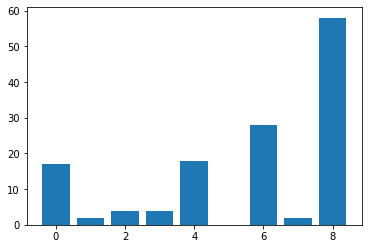

ccabc01c_copy2_cfb5dd80_25pct


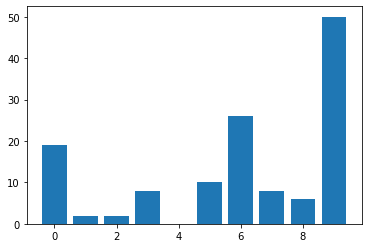

ccabc01c_copy3_cfb5dd80_50pct


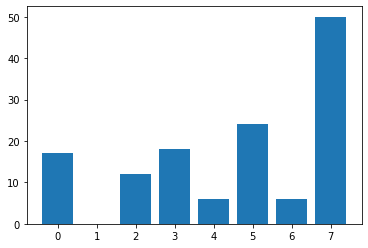

cfb5dd80_copy1_ccabc01c_10pct


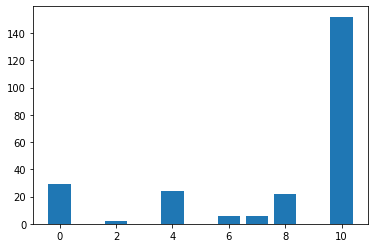

cfb5dd80_copy2_ccabc01c_25pct


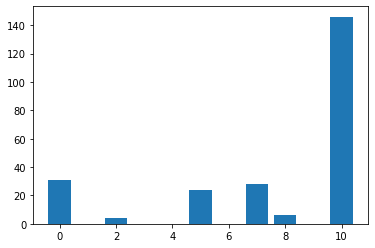

cfb5dd80_copy3_ccabc01c_50pct


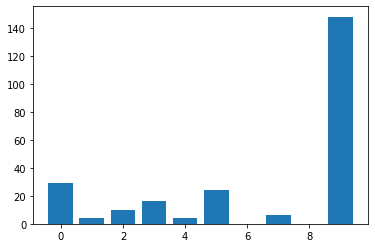

In [149]:
clonal_cluster = plot_filter_cluster_distr_loop(high_purity_merged_mafs, filter_col='in_matched_maf')

ccabc01c_copy1_cfb5dd80_10pct


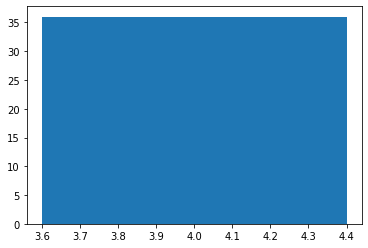

ccabc01c_copy2_cfb5dd80_25pct


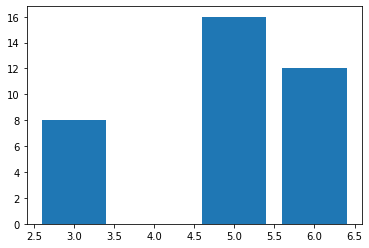

ccabc01c_copy3_cfb5dd80_50pct


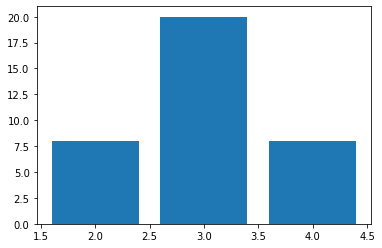

cfb5dd80_copy1_ccabc01c_10pct


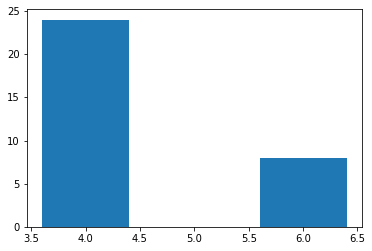

cfb5dd80_copy2_ccabc01c_25pct


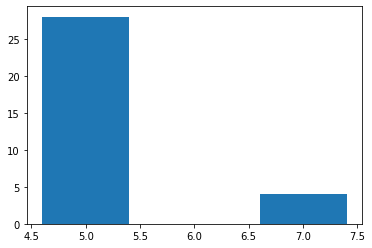

cfb5dd80_copy3_ccabc01c_50pct


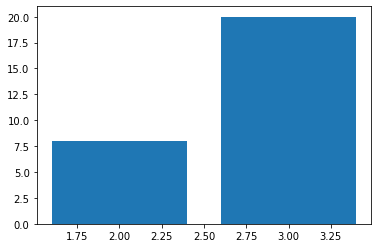

In [137]:
# plot_filter_cluster_distr(clonal_cluster, filter_col='pass_tumor_only_filter')

for pair_id, row in high_purity_merged_mafs.iterrows():
    merged_maf = pd.read_csv(row['merged_maf_fn'], sep='\t')
    merged_maf = clonal_cluster.merge(merged_maf, how='left', on=maf_merge_cols)
    plot_filter_cluster_distr(merged_maf, filter_col='pass_phylogic_cp_filter')
        

ccabc01c_copy1_cfb5dd80_10pct


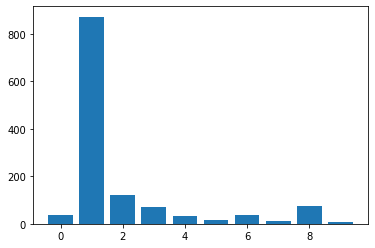

ccabc01c_copy2_cfb5dd80_25pct


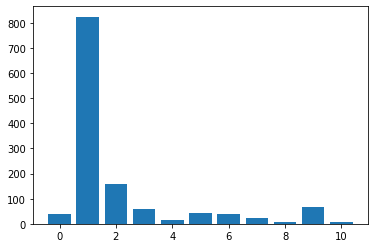

ccabc01c_copy3_cfb5dd80_50pct


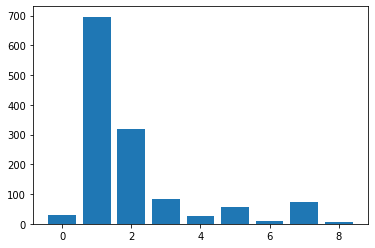

cfb5dd80_copy1_ccabc01c_10pct


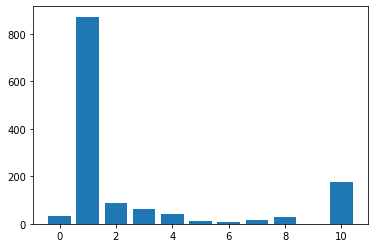

cfb5dd80_copy2_ccabc01c_25pct


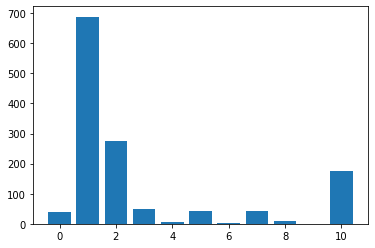

cfb5dd80_copy3_ccabc01c_50pct


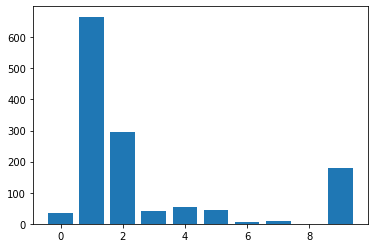

,Hugo_Symbol,Chromosome,Start_position,End_position,Variant_Classification,Reference_Allele,Tumor_Seq_Allele2
12,CSDE1,1,115262207,115262207,Missense_Mutation,G,C
13,CSDE1,1,115262207,115262207,Missense_Mutation,G,C
29,FIP1L1,4,54852751,54852751,Intron,C,T
30,FIP1L1,4,54852751,54852751,Intron,C,T
51,DPP6,7,153750027,153750027,Missense_Mutation,C,A
52,DPP6,7,153750027,153750027,Missense_Mutation,C,A
53,ASAP1,8,131070268,131070268,Missense_Mutation,C,T
54,ASAP1,8,131070268,131070268,Missense_Mutation,C,T
70,WT1,11,32413612,32413612,Splice_Site,T,C
71,WT1,11,32413612,32413612,Splice_Site,T,C


In [150]:
plot_filter_cluster_distr_loop(high_purity_merged_mafs, filter_col='pass_tumor_only_filter')

KeyError: 'Cluster_Assignment'

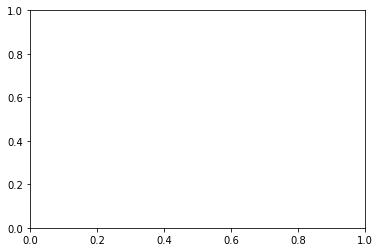

In [151]:
plot_filter_cluster_distr(high_purity_merged_mafs, filter_col='pass_multisample_tonly')

ccabc01c_copy1_cfb5dd80_10pct


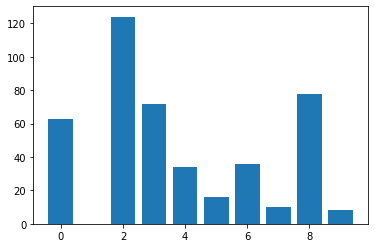

ccabc01c_copy2_cfb5dd80_25pct


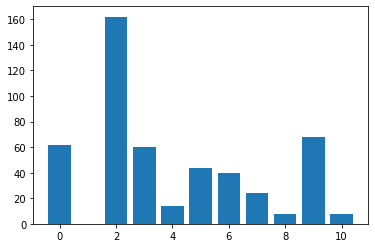

ccabc01c_copy3_cfb5dd80_50pct


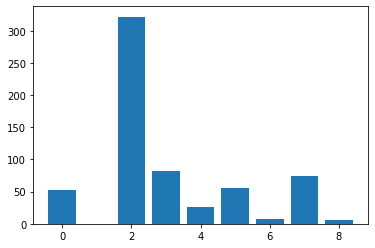

cfb5dd80_copy1_ccabc01c_10pct


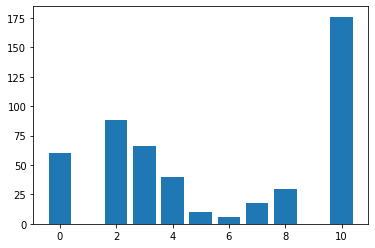

cfb5dd80_copy2_ccabc01c_25pct


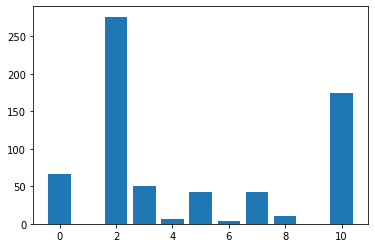

cfb5dd80_copy3_ccabc01c_50pct


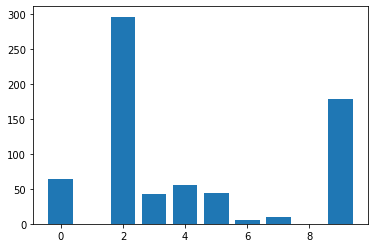

,Hugo_Symbol,Chromosome,Start_position,End_position,Variant_Classification,Reference_Allele,Tumor_Seq_Allele2
12,CSDE1,1,115262207,115262207,Missense_Mutation,G,C
13,CSDE1,1,115262207,115262207,Missense_Mutation,G,C
29,FIP1L1,4,54852751,54852751,Intron,C,T
30,FIP1L1,4,54852751,54852751,Intron,C,T
51,DPP6,7,153750027,153750027,Missense_Mutation,C,A
52,DPP6,7,153750027,153750027,Missense_Mutation,C,A
53,ASAP1,8,131070268,131070268,Missense_Mutation,C,T
54,ASAP1,8,131070268,131070268,Missense_Mutation,C,T
70,WT1,11,32413612,32413612,Splice_Site,T,C
71,WT1,11,32413612,32413612,Splice_Site,T,C


In [152]:
plot_filter_cluster_distr_loop(high_purity_merged_mafs, filter_col='pass_phylogic_cp_filter')